In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Dados hipotéticos (substitua pelos seus dados reais em um arquivo CSV)
data = pd.read_csv('data_/AAPL.csv')
df = pd.DataFrame(data)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,133.520004,133.610001,126.760002,129.410004,127.503647,143301900
1,2021-01-05,128.889999,131.740005,128.429993,131.009995,129.080063,97664900
2,2021-01-06,127.720001,131.050003,126.379997,126.599998,124.735031,155088000
3,2021-01-07,128.360001,131.630005,127.860001,130.919998,128.991409,109578200
4,2021-01-08,132.429993,132.630005,130.229996,132.050003,130.104736,105158200


In [3]:
# Função para calcular as médias móveis
def calculate_moving_averages(data, short_window, long_window):
    data['Short_MA'] = data['Adj Close'].rolling(window=short_window).mean()
    data['Long_MA'] = data['Adj Close'].rolling(window=long_window).mean()


In [4]:
# Função para identificar os cruzamentos
def identify_crossings(data):
    crossings = []
    for i in range(1, len(data)):
        if data['Short_MA'][i] > data['Long_MA'][i] and data['Short_MA'][i - 1] <= data['Long_MA'][i - 1]:
            crossings.append((data['Date'][i], 'Golden Cross'))
        elif data['Short_MA'][i] < data['Long_MA'][i] and data['Short_MA'][i - 1] >= data['Long_MA'][i - 1]:
            crossings.append((data['Date'][i], 'Death Cross'))
    return crossings

In [5]:
# Função para plotar os resultados
def plot_strategy(data, crossings):
    plt.figure(figsize=(20, 10))
    plt.plot(data['Date'], data['Adj Close'], label='Preço')
    plt.plot(data['Date'], data['Short_MA'], label='Média Móvel Curta', linestyle='dashed')
    plt.plot(data['Date'], data['Long_MA'], label='Média Móvel Longa', linestyle='dashed')
    for date, cross_type in crossings:
        plt.axvline(date, color='red', linestyle='dotted', label=cross_type)
#   plt.legend()
#   plt.xlabel('Data') # muito pequeno
    plt.ylabel('Preço') 
    plt.title('Estratégia de Cruzamento de Médias Móveis')
    plt.show()

Cruzamentos:
2021-04-13: Golden Cross
2021-05-17: Death Cross
2021-06-21: Golden Cross
2021-09-22: Death Cross
2021-10-27: Golden Cross
2022-01-25: Death Cross
2022-02-09: Golden Cross
2022-02-16: Death Cross
2022-03-28: Golden Cross
2022-04-22: Death Cross
2022-07-15: Golden Cross
2022-09-09: Death Cross
2022-11-21: Golden Cross
2022-12-09: Death Cross
2023-01-27: Golden Cross


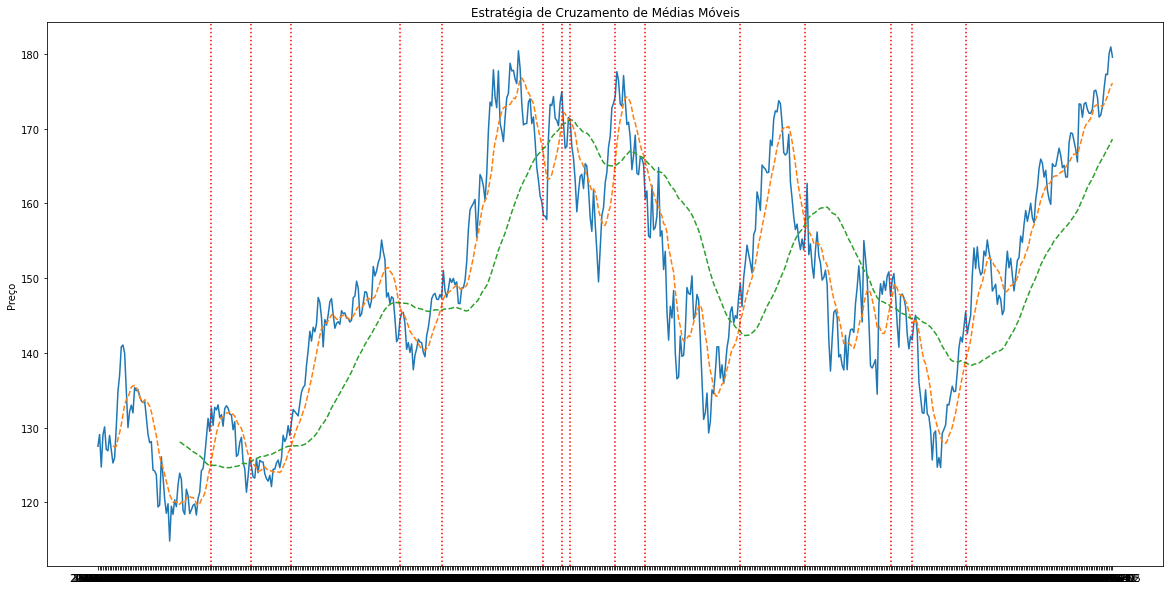

In [6]:
# Parâmetros para a análise
short_window = 10
long_window = 50

# Realiza a análise
calculate_moving_averages(df, short_window, long_window)
crossings = identify_crossings(df)

# Exibe o resultado
print("Cruzamentos:")
for date, cross_type in crossings:
    # Verifica se 'date' é uma string e converte para objeto de data, se necessário
    if isinstance(date, str):
        date = datetime.strptime(date, '%Y-%m-%d')  # Converte a string para objeto de data
    print(f"{date.strftime('%Y-%m-%d')}: {cross_type}")

# Plota o gráfico
plot_strategy(df, crossings)

In [7]:
# Função para calcular o retorno acumulado da estratégia
def calculate_cumulative_returns(data, short_window, long_window):
    data['Position'] = 0
    data.loc[data['Short_MA'] > data['Long_MA'], 'Position'] = 1
    data['Returns'] = data['Adj Close'].pct_change() * data['Position'].shift()
    cumulative_returns = (data['Returns'] + 1).cumprod()
    if len(cumulative_returns) > 0:
        return cumulative_returns.iloc[-1]  # Retorna o último valor do DataFrame
    else:
        return 1  # Retorna 1 se não houver dados para calcular o retorno acumulado

In [8]:
# Função para calcular a taxa de acerto da estratégia
def calculate_accuracy(data, short_window, long_window):
    data['Signal'] = 0
    data.loc[data['Short_MA'] > data['Long_MA'], 'Signal'] = 1
    data['Actual_Signal'] = data['Signal'].shift()
    correct_signals = data[data['Signal'] == data['Actual_Signal']]
    accuracy = len(correct_signals) / len(data)
    return accuracy

Melhor combinação de janelas móveis: Short Window = 5, Long Window = 20
Retorno acumulado: 1.61


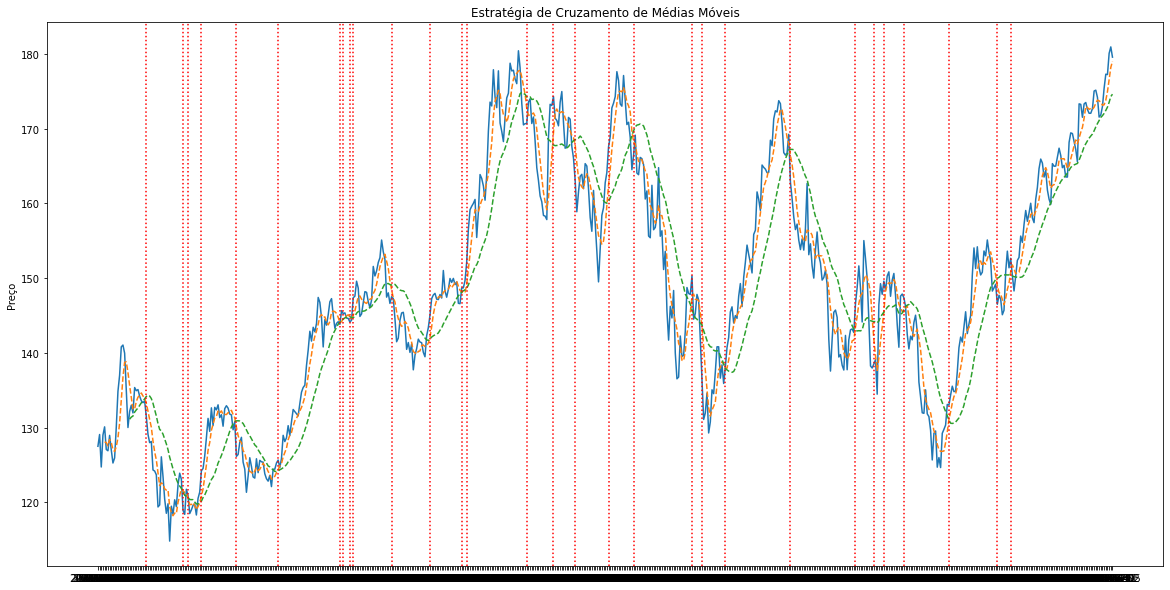

In [9]:
# Parâmetros para otimização
short_window_range = range(5, 21, 5)
long_window_range = range(20, 101, 10)

# Otimiza a estratégia
best_cumulative_returns = 0
best_short_window = 0
best_long_window = 0

for short_window in short_window_range:
    for long_window in long_window_range:
        if short_window >= long_window:
            continue

        calculate_moving_averages(df, short_window, long_window)
        cumulative_returns = calculate_cumulative_returns(df, short_window, long_window)

        if cumulative_returns > best_cumulative_returns:
            best_cumulative_returns = cumulative_returns
            best_short_window = short_window
            best_long_window = long_window


# Exibe os resultados da otimização
print(f"Melhor combinação de janelas móveis: Short Window = {best_short_window}, Long Window = {best_long_window}")
print(f"Retorno acumulado: {best_cumulative_returns:.2f}")

# Re-calcular as médias móveis com as melhores janelas
calculate_moving_averages(df, best_short_window, best_long_window)
crossings = identify_crossings(df)

# Plota o gráfico atualizado com a melhor estratégia
plot_strategy(df, crossings)

In [10]:
# Função para calcular o drawdown máximo da estratégia
def calculate_max_drawdown(data):
    data['Cumulative_Returns'] = (data['Returns'] + 1).cumprod()
    data['Peak'] = data['Cumulative_Returns'].cummax()
    data['Drawdown'] = data['Cumulative_Returns'] / data['Peak'] - 1
    max_drawdown = data['Drawdown'].min()
    return max_drawdown

In [11]:
# Calcula o drawdown máximo da melhor estratégia
calculate_moving_averages(df, best_short_window, best_long_window)
df['Returns'] = df['Adj Close'].pct_change() * df['Position'].shift()
max_drawdown = calculate_max_drawdown(df)

Melhor combinação de janelas móveis: Short Window = 5, Long Window = 20
Retorno acumulado: 1.61
Drawdown máximo: -35.38%


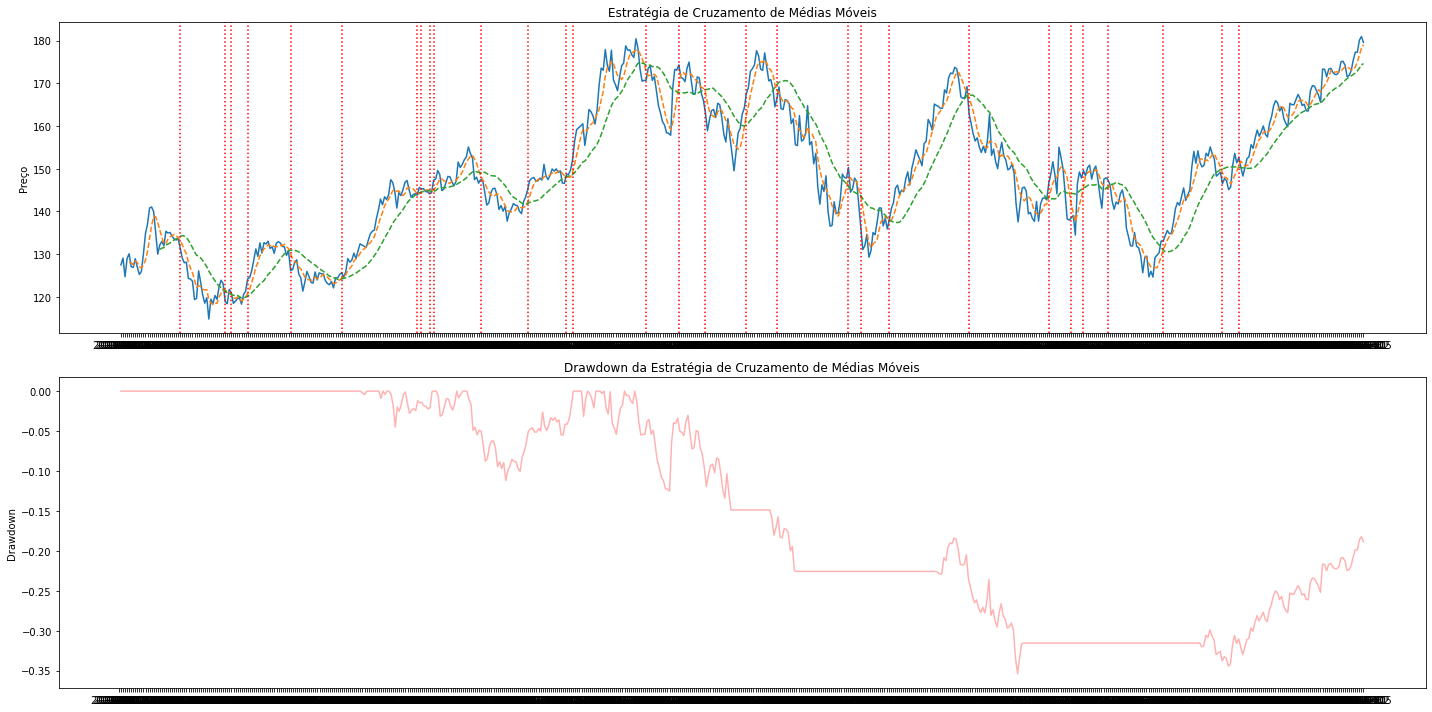

In [12]:
# Exibe o resultado da otimização com o drawdown máximo
print(f"Melhor combinação de janelas móveis: Short Window = {best_short_window}, Long Window = {best_long_window}")
print(f"Retorno acumulado: {best_cumulative_returns:.2f}")
print(f"Drawdown máximo: {max_drawdown:.2%}")

# Plota o gráfico atualizado com a melhor estratégia
plt.figure(figsize=(20, 10))

# Subplot para a estratégia da média móvel
plt.subplot(2, 1, 1)
plt.plot(df['Date'], df['Adj Close'], label='Preço')
plt.plot(df['Date'], df['Short_MA'], label='Média Móvel Curta', linestyle='dashed')
plt.plot(df['Date'], df['Long_MA'], label='Média Móvel Longa', linestyle='dashed')
for date, cross_type in crossings:
    plt.axvline(date, color='red', linestyle='dotted', label=cross_type)
#plt.legend()
plt.ylabel('Preço')
plt.title('Estratégia de Cruzamento de Médias Móveis')

# Subplot para o drawdown
plt.subplot(2, 1, 2)
plt.plot(df['Date'], df['Drawdown'], color='red', alpha=0.3, label='Drawdown')
#plt.legend()
# plt.xlabel('Data') # muito pequeno
plt.ylabel('Drawdown')
plt.title('Drawdown da Estratégia de Cruzamento de Médias Móveis')

plt.tight_layout()  # Para evitar sobreposição de rótulos e títulos
plt.show()

In [13]:
# Calcula os retornos positivos
df['Positive_Returns'] = df['Returns'].copy()
df['Positive_Returns'][df['Positive_Returns'] < 0] = 0

In [14]:
# Calcula o drawdown máximo da melhor estratégia
calculate_moving_averages(df, best_short_window, best_long_window)
df['Returns'] = df['Adj Close'].pct_change() * df['Position'].shift()
max_drawdown = calculate_max_drawdown(df)

In [15]:
# Função para calcular o Índice de Sharpe
def calculate_sharpe_ratio(data):
    excess_returns = data['Returns'] - 0.01 / 252  # Assumindo taxa de juros livre de risco de 1% ao ano
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
    return sharpe_ratio

Melhor combinação de janelas móveis: Short Window = 5, Long Window = 20
Retorno acumulado: 1.61
Drawdown máximo: -35.38%
Índice de Sharpe: 0.27


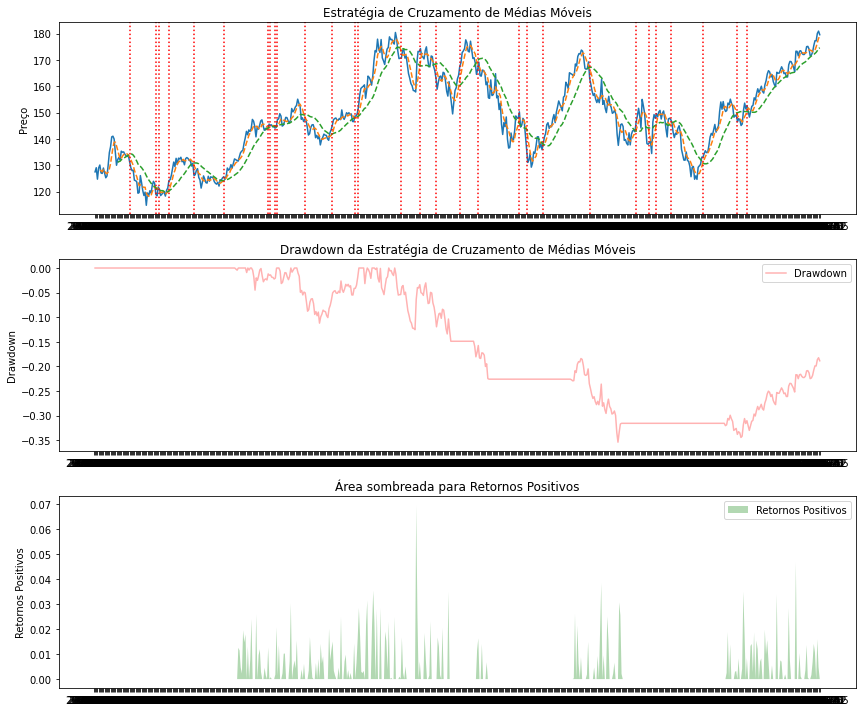

In [16]:
# Calcula o Índice de Sharpe da melhor estratégia
sharpe_ratio = calculate_sharpe_ratio(df)

# Exibe o resultado da otimização com o drawdown máximo e o Índice de Sharpe
print(f"Melhor combinação de janelas móveis: Short Window = {best_short_window}, Long Window = {best_long_window}")
print(f"Retorno acumulado: {best_cumulative_returns:.2f}")
print(f"Drawdown máximo: {max_drawdown:.2%}")
print(f"Índice de Sharpe: {sharpe_ratio:.2f}")

# Plota o gráfico atualizado com a melhor estratégia, drawdown e área sombreada para retornos positivos
plt.figure(figsize=(20, 10))

# Subplot para a estratégia da média móvel
plt.subplot(3, 1, 1)
plt.plot(df['Date'], df['Adj Close'], label='Preço')
plt.plot(df['Date'], df['Short_MA'], label='Média Móvel Curta', linestyle='dashed')
plt.plot(df['Date'], df['Long_MA'], label='Média Móvel Longa', linestyle='dashed')
for date, cross_type in crossings:
    plt.axvline(date, color='red', linestyle='dotted', label=cross_type)
#plt.legend()
plt.ylabel('Preço')
plt.title('Estratégia de Cruzamento de Médias Móveis')

# Subplot para o drawdown
plt.subplot(3, 1, 2)
plt.plot(df['Date'], df['Drawdown'], color='red', alpha=0.3, label='Drawdown')
plt.legend()
plt.ylabel('Drawdown')
plt.title('Drawdown da Estratégia de Cruzamento de Médias Móveis')

# Subplot para a área sombreada de retornos positivos
plt.subplot(3, 1, 3)
plt.fill_between(df['Date'], 0, df['Positive_Returns'], facecolor='green', alpha=0.3, label='Retornos Positivos')
plt.legend()
#plt.xlabel('Data')
plt.ylabel('Retornos Positivos')
plt.title('Área sombreada para Retornos Positivos')

plt.tight_layout()  # Para evitar sobreposição de rótulos e títulos
plt.show()

In [17]:
# Função para adicionar a estratégia de stop loss
def apply_stop_loss(data, stop_loss_percent):
    data['Stop_Loss'] = data['Adj Close'] * (1 - stop_loss_percent)
    data['Stop_Loss_Exceeded'] = data['Position'] & (data['Adj Close'] < data['Stop_Loss'])
    data.loc[data['Stop_Loss_Exceeded'], 'Position'] = 0
    stop_loss_count = data['Stop_Loss_Exceeded'].sum()
    stop_loss_values = data.loc[data['Stop_Loss_Exceeded'], 'Adj Close'] - data.loc[data['Stop_Loss_Exceeded'], 'Stop_Loss']
    return stop_loss_count, stop_loss_values


# Parâmetros adicionais para a estratégia de stop loss
stop_loss_percent = 0.05  # Por exemplo, 5% de stop loss

# Aplica a estratégia de stop loss na melhor estratégia e obtém informações sobre o stop loss
stop_loss_count, stop_loss_values = apply_stop_loss(df, stop_loss_percent)

# Recalcula o retorno acumulado e o drawdown máximo com a estratégia de stop loss
best_cumulative_returns_with_sl = calculate_cumulative_returns(df, best_short_window, best_long_window)
max_drawdown_with_sl = calculate_max_drawdown(df)

# Exibe o resultado com a estratégia de stop loss
print(f"Melhor combinação de janelas móveis: Short Window = {best_short_window}, Long Window = {best_long_window}")
print(f"Retorno acumulado: {best_cumulative_returns_with_sl:.2f}")
print(f"Drawdown máximo: {max_drawdown_with_sl:.2%}")

# Plota o gráfico atualizado com a melhor estratégia, drawdown, área sombreada para retornos negativos e stop loss
plt.figure(figsize=(20, 10))

# Subplot para a estratégia da média móvel
plt.subplot(4, 1, 1)
plt.plot(df['Date'], df['Adj Close'], label='Preço')
plt.plot(df['Date'], df['Short_MA'], label='Média Móvel Curta', linestyle='dashed')
plt.plot(df['Date'], df['Long_MA'], label='Média Móvel Longa', linestyle='dashed')
for date, cross_type in crossings:
    plt.axvline(date, color='red', linestyle='dotted', label=cross_type)
#plt.legend()
plt.ylabel('Preço')
plt.title('Estratégia de Cruzamento de Médias Móveis')

# Subplot para o drawdown
plt.subplot(4, 1, 2)
plt.plot(df['Date'], df['Drawdown'], color='red', alpha=0.3, label='Drawdown')
plt.legend()
plt.ylabel('Drawdown')
plt.title('Drawdown da Estratégia de Cruzamento de Médias Móveis')
# Subplot para a área sombreada de retornos positivos
plt.subplot(4, 1, 3)
positive_returns = df[df['Returns'] >= 0]
plt.fill_between(positive_returns['Date'], 0, positive_returns['Returns'], facecolor='green', alpha=0.3, label='Retornos Positivos')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Retornos Positivos')
plt.title('Área sombreada para Retornos Positivos')

# Subplot para o stop loss
plt.subplot(4, 1, 4)
plt.scatter(df.loc[df['Stop_Loss_Exceeded'], 'Date'], df.loc[df['Stop_Loss_Exceeded'], 'Adj Close'], color='red', marker='x', label='Stop Loss')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Stop Loss')

# Exibe informações sobre o stop loss
stop_loss_total_loss = stop_loss_values.sum()
print(f"Total de Stop Loss ocorridos: {stop_loss_count}")
print(f"Perda Total de Stop Loss: {stop_loss_total_loss:.2f}")

plt.tight_layout()  # Para evitar sobreposição de rótulos e títulos
plt.show()

Melhor combinação de janelas móveis: Short Window = 5, Long Window = 20
Retorno acumulado: 1.61
Drawdown máximo: -20.27%
Total de Stop Loss ocorridos: 0
Perda Total de Stop Loss: 0.00


In [ ]:
# Função para adicionar a estratégia de take profit
def apply_take_profit(data, take_profit_percent):
    data['Take_Profit'] = data['Adj Close'] * (1 + take_profit_percent)
    data['Take_Profit_Exceeded'] = data['Position'] & (data['Adj Close'] > data['Take_Profit'])
    data.loc[data['Take_Profit_Exceeded'], 'Position'] = 0

In [ ]:
# Parâmetros adicionais para a estratégia de take profit
take_profit_percent = 0.03  # Por exemplo, 3% de take profit

# Aplica a estratégia de take profit na melhor estratégia com stop loss
apply_take_profit(df, take_profit_percent)

# Recalcula o retorno acumulado e o drawdown máximo com as estratégias de stop loss e take profit
best_cumulative_returns_with_sl_tp = calculate_cumulative_returns(df, best_short_window, best_long_window)
max_drawdown_with_sl_tp = calculate_max_drawdown(df)

# Exibe o resultado com as estratégias de stop loss e take profit
print(f"Melhor combinação de janelas móveis: Short Window = {best_short_window}, Long Window = {best_long_window}")
print(f"Retorno acumulado: {best_cumulative_returns_with_sl_tp:.2f}")
print(f"Drawdown máximo: {max_drawdown_with_sl_tp:.2%}")

In [ ]:
# Plota o gráfico atualizado com a melhor estratégia, drawdown, áreas sombreadas para retornos negativos, stop loss e take profit
plt.figure(figsize=(20, 10))

# Subplot para a estratégia da média móvel
plt.subplot(5, 1, 1)
plt.plot(df['Date'], df['Adj Close'], label='Preço')
plt.plot(df['Date'], df['Short_MA'], label='Média Móvel Curta', linestyle='dashed')
plt.plot(df['Date'], df['Long_MA'], label='Média Móvel Longa', linestyle='dashed')
for date, cross_type in crossings:
    plt.axvline(date, color='red', linestyle='dotted', label=cross_type)
plt.legend()
plt.ylabel('Preço')
plt.title('Estratégia de Cruzamento de Médias Móveis')

# Subplot para o drawdown
plt.subplot(5, 1, 2)
plt.plot(df['Date'], df['Drawdown'], color='red', alpha=0.3, label='Drawdown')
plt.legend()
plt.ylabel('Drawdown')
plt.title('Drawdown da Estratégia de Cruzamento de Médias Móveis')

# Subplot para a área sombreada de retornos positivos
plt.subplot(5, 1, 3)
positive_returns = df[df['Returns'] >= 0]
plt.fill_between(positive_returns['Date'], 0, positive_returns['Returns'], facecolor='green', alpha=0.3, label='Retornos Positivos')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Retornos Positivos')
plt.title('Área sombreada para Retornos Positivos')

# Subplot para o stop loss
plt.subplot(5, 1, 4)
plt.scatter(df.loc[df['Stop_Loss_Exceeded'], 'Date'], df.loc[df['Stop_Loss_Exceeded'], 'Adj Close'], color='red', marker='x', label='Stop Loss')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Stop Loss')

# Subplot para o take profit
plt.subplot(5, 1, 5)
plt.scatter(df.loc[df['Take_Profit_Exceeded'], 'Date'], df.loc[df['Take_Profit_Exceeded'], 'Adj Close'], color='green', marker='x', label='Take Profit')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Take Profit')

plt.tight_layout()  # Para evitar sobreposição de rótulos e títulos
plt.show()

In [ ]:
# Função para realizar a análise de sensibilidade
def sensitivity_analysis(data, short_window_range, long_window_range, stop_loss_percent, take_profit_percent):
    results = []

    for short_window in short_window_range:
        for long_window in long_window_range:
            if short_window >= long_window:
                continue

            calculate_moving_averages(data, short_window, long_window)
            crossings = identify_crossings(data)
            apply_stop_loss(data, stop_loss_percent)
            apply_take_profit(data, take_profit_percent)
            cumulative_returns = calculate_cumulative_returns(data, short_window, long_window)
            max_drawdown = calculate_max_drawdown(data)
            sharpe_ratio = calculate_sharpe_ratio(data)
            
            result = {
                'Short_Window': short_window,
                'Long_Window': long_window,
                'Cumulative_Returns': cumulative_returns,
                'Max_Drawdown': max_drawdown,
                'Sharpe_Ratio': sharpe_ratio
            }
            results.append(result)

    return results

# Parâmetros para a análise de sensibilidade
short_window_range = range(5, 21, 5) #5, 21, 5
long_window_range = range(20, 101, 5) #20, 101, 5
stop_loss_percent = 0.05
take_profit_percent = 0.03

# Realiza a análise de sensibilidade
sensitivity_results = sensitivity_analysis(df.copy(), short_window_range, long_window_range, stop_loss_percent, take_profit_percent)

# Exibe os resultados da análise de sensibilidade
print("Resultados da Análise de Sensibilidade:")
for result in sensitivity_results:
    print(f"Short Window: {result['Short_Window']}, \
            Long Window: {result['Long_Window']}, \
            Retorno Acumulado: {result['Cumulative_Returns']:.2f}, \
            Drawdown Máximo: {result['Max_Drawdown']:.2%}, \
            Índice de Sharpe: {result['Sharpe_Ratio']:.2f}")
    
# Cria um DataFrame com os resultados da análise de sensibilidade
df_resultados = pd.DataFrame(sensitivity_results)

# Salva o DataFrame em um arquivo CSV
df_resultados.to_csv('data_/resultados_analise_sensibilidade.csv', index=False)

print("Resultados salvos em resultados_analise_sensibilidade.csv")

In [ ]:
# Função para realizar a análise de desempenho comparativa
def comparative_performance_analysis(data, short_window_range, long_window_range, stop_loss_range, take_profit_range):
    results = []

    for short_window in short_window_range:
        for long_window in long_window_range:
            if short_window >= long_window:
                continue

            for stop_loss_percent in stop_loss_range:
                for take_profit_percent in take_profit_range:
                    df_copy = data.copy()
                    calculate_moving_averages(df_copy, short_window, long_window)
                    crossings = identify_crossings(df_copy)
                    apply_stop_loss(df_copy, stop_loss_percent)
                    apply_take_profit(df_copy, take_profit_percent)
                    cumulative_returns = calculate_cumulative_returns(df_copy, short_window, long_window)
                    max_drawdown = calculate_max_drawdown(df_copy)
                    sharpe_ratio = calculate_sharpe_ratio(df_copy)

                    result = {
                        'Short_Window': short_window,
                        'Long_Window': long_window,
                        'Stop_Loss_Percent': stop_loss_percent,
                        'Take_Profit_Percent': take_profit_percent,
                        'Cumulative_Returns': cumulative_returns,
                        'Max_Drawdown': max_drawdown,
                        'Sharpe_Ratio': sharpe_ratio
                    }
                    results.append(result)

    return results

# Parâmetros para a análise de desempenho comparativa
short_window_range = range(5, 21, 5)
long_window_range = range(20, 101, 10)
stop_loss_range = [0.02, 0.05, 0.10]
take_profit_range = [0.02, 0.03, 0.05]

# Realiza a análise de desempenho comparativa
comparative_results = comparative_performance_analysis(df.copy(), short_window_range, long_window_range, stop_loss_range, take_profit_range)

# Encontra a melhor estratégia com base no Índice de Sharpe
best_strategy = max(comparative_results, key=lambda x: x['Sharpe_Ratio'])

# Exibe a melhor estratégia
print("Melhor Estratégia:")
print(f"Short Window: {best_strategy['Short_Window']}, Long Window: {best_strategy['Long_Window']}, Stop Loss: {best_strategy['Stop_Loss_Percent']}, Take Profit: {best_strategy['Take_Profit_Percent']}")
print(f"Retorno Acumulado: {best_strategy['Cumulative_Returns']:.2f}, Drawdown Máximo: {best_strategy['Max_Drawdown']:.2%}, Índice de Sharpe: {best_strategy['Sharpe_Ratio']:.2f}")

In [ ]:
# Função para realizar o backtest da melhor estratégia
def backtest_strategy(data, short_window, long_window, stop_loss_percent, take_profit_percent):
    df_copy = data.copy()
    calculate_moving_averages(df_copy, short_window, long_window)
    crossings = identify_crossings(df_copy)
    apply_stop_loss(df_copy, stop_loss_percent)
    apply_take_profit(df_copy, take_profit_percent)
    df_copy['Position_Shifted'] = df_copy['Position'].shift()
    df_copy['Trades'] = (df_copy['Position'] != df_copy['Position_Shifted']).astype(int)
    num_trades = df_copy['Trades'].sum()
    win_trades = df_copy[df_copy['Returns'] > 0]['Trades'].sum()
    loss_trades = df_copy[df_copy['Returns'] < 0]['Trades'].sum()
    accuracy = win_trades / num_trades if num_trades > 0 else 0
    profit_factor = df_copy[df_copy['Returns'] > 0]['Returns'].sum() / abs(df_copy[df_copy['Returns'] < 0]['Returns'].sum())
    reward_to_risk_ratio = abs(df_copy[df_copy['Returns'] > 0]['Returns'].mean() / df_copy[df_copy['Returns'] < 0]['Returns'].mean())
    return num_trades, accuracy, profit_factor, reward_to_risk_ratio

# Realiza o backtest da melhor estratégia
num_trades, accuracy, profit_factor, reward_to_risk_ratio = backtest_strategy(df.copy(), best_strategy['Short_Window'], best_strategy['Long_Window'], best_strategy['Stop_Loss_Percent'], best_strategy['Take_Profit_Percent'])

# Exibe as métricas do backtest
print("Métricas do Backtest da Melhor Estratégia:")
print(f"Número de Trades: {num_trades}")
print(f"Taxa de Acerto: {accuracy:.2%}")
print(f"Fator de Lucro: {profit_factor:.2f}")
print(f"Relação de Recompensa/Risco: {reward_to_risk_ratio:.2f}")

In [ ]:
# Função para calcular o capital acumulado ao longo do tempo durante o backtest
def calculate_accumulated_capital(data, short_window, long_window, stop_loss_percent, take_profit_percent):
    df_copy = data.copy()
    calculate_moving_averages(df_copy, short_window, long_window)
    crossings = identify_crossings(df_copy)
    apply_stop_loss(df_copy, stop_loss_percent)
    apply_take_profit(df_copy, take_profit_percent)
    df_copy['Returns_Cumulative'] = (1 + df_copy['Returns']).cumprod()
    df_copy['Capital'] = 100000 * df_copy['Returns_Cumulative']
    return df_copy

# Calcula o capital acumulado durante o backtest da melhor estratégia
backtest_results = calculate_accumulated_capital(df.copy(), best_strategy['Short_Window'], best_strategy['Long_Window'], best_strategy['Stop_Loss_Percent'], best_strategy['Take_Profit_Percent'])

# Plota o gráfico do capital acumulado ao longo do tempo durante o backtest
plt.figure(figsize=(12, 6))
plt.plot(backtest_results['Date'], backtest_results['Capital'])
plt.xlabel('Data')
plt.ylabel('Capital Acumulado')
plt.title('Capital Acumulado durante o Backtest da Melhor Estratégia')
plt.show()

In [ ]:
# Função para realizar a análise de sensibilidade para stop loss e take profit
def sensitivity_analysis_stop_loss_take_profit(data, short_window, long_window, stop_loss_range, take_profit_range):
    results = []

    for stop_loss_percent in stop_loss_range:
        for take_profit_percent in take_profit_range:
            df_copy = data.copy()
            calculate_moving_averages(df_copy, short_window, long_window)
            crossings = identify_crossings(df_copy)
            apply_stop_loss(df_copy, stop_loss_percent)
            apply_take_profit(df_copy, take_profit_percent)
            cumulative_returns = calculate_cumulative_returns(df_copy, short_window, long_window)
            max_drawdown = calculate_max_drawdown(df_copy)
            sharpe_ratio = calculate_sharpe_ratio(df_copy)

            result = {
                'Stop_Loss_Percent': stop_loss_percent,
                'Take_Profit_Percent': take_profit_percent,
                'Cumulative_Returns': cumulative_returns,
                'Max_Drawdown': max_drawdown,
                'Sharpe_Ratio': sharpe_ratio
            }
            results.append(result)

    return results

# Parâmetros para a análise de sensibilidade para stop loss e take profit
stop_loss_range = [0.02, 0.05, 0.08]
take_profit_range = [0.02, 0.03, 0.05, 0.08]

# Realiza a análise de sensibilidade para stop loss e take profit
sensitivity_results_sl_tp = sensitivity_analysis_stop_loss_take_profit(df.copy(), best_strategy['Short_Window'], best_strategy['Long_Window'], stop_loss_range, take_profit_range)

# Encontra a melhor combinação de stop loss e take profit com base no Índice de Sharpe
best_sl_tp_strategy = max(sensitivity_results_sl_tp, key=lambda x: x['Sharpe_Ratio'])

# Exibe a melhor combinação de stop loss e take profit
print("Melhor Combinação de Stop Loss e Take Profit:")
print(f"Stop Loss: {best_sl_tp_strategy['Stop_Loss_Percent']}, Take Profit: {best_sl_tp_strategy['Take_Profit_Percent']}")
print(f"Retorno Acumulado: {best_sl_tp_strategy['Cumulative_Returns']:.2f}, Drawdown Máximo: {best_sl_tp_strategy['Max_Drawdown']:.2%}, Índice de Sharpe: {best_sl_tp_strategy['Sharpe_Ratio']:.2f}")

In [ ]:
stop

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Função para criar o sinal de compra (1), venda (-1) ou ausência de sinal (0)
def create_signal(data):
    data['Signal'] = 0
    data.loc[data['Position'] == 1, 'Signal'] = 1
    data.loc[data['Position'] == -1, 'Signal'] = -1
    return data

In [ ]:
# Adiciona o sinal ao conjunto de dados
df = create_signal(df)
df.info()

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.info()

In [ ]:
# Seleciona os recursos para o modelo de machine learning
X = df[['Short_MA', 'Long_MA', 'Adj Close']]
y = df['Signal']

# Divide o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cria e treina o modelo de machine learning (usaremos um classificador de Random Forest)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Realiza as previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Exibe as métricas de desempenho do modelo
print("Desempenho do Modelo de Machine Learning:")
print(f"Acurácia: {accuracy:.2f}")
print("Relatório de Classificação:")
print(report)

In [ ]:
# Função para realizar o backtest da estratégia preditiva
def backtest_with_predictions(data, model):
    df_copy = data.copy()
    df_copy['Predicted_Signal'] = model.predict(data[['Short_MA', 'Long_MA', 'Adj Close']])
    df_copy['Position_Predicted'] = df_copy['Predicted_Signal'].diff()
    df_copy['Position'] = df_copy['Position_Predicted'].apply(lambda x: 1 if x == 1 else (-1 if x == -1 else 0))
    df_copy.drop(columns=['Predicted_Signal', 'Position_Predicted'], inplace=True)
    df_copy = create_signal(df_copy)
    return df_copy

# Realiza o backtest da estratégia preditiva com o modelo de machine learning
df_backtest_predicted = backtest_with_predictions(df, model)

# Calcula as métricas de desempenho do backtest preditivo
num_trades_predicted, accuracy_predicted, profit_factor_predicted, reward_to_risk_ratio_predicted = backtest_strategy(df_backtest_predicted, best_strategy['Short_Window'], best_strategy['Long_Window'], best_strategy['Stop_Loss_Percent'], best_strategy['Take_Profit_Percent'])

# Exibe as métricas do backtest preditivo
print("Métricas do Backtest com o Modelo Preditivo:")
print(f"Número de Trades: {num_trades_predicted}")
print(f"Taxa de Acerto: {accuracy_predicted:.2%}")
print(f"Fator de Lucro: {profit_factor_predicted:.2f}")
print(f"Relação de Recompensa/Risco: {reward_to_risk_ratio_predicted:.2f}")

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definindo os hiperparâmetros a serem testados no Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Criando o classificador do Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Criando o objeto do Grid Search com validação cruzada
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Realizando o Grid Search para encontrar os melhores hiperparâmetros
grid_search.fit(X_train, y_train)

# Exibindo os melhores hiperparâmetros encontrados
print("Melhores Hiperparâmetros:")
print(grid_search.best_params_)

# Criando o modelo com os melhores hiperparâmetros encontrados
best_model = grid_search.best_estimator_

# Realizando as previsões no conjunto de teste com o melhor modelo
y_pred_best = best_model.predict(X_test)

# Avaliando o desempenho do melhor modelo
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)

# Exibindo as métricas de desempenho do melhor modelo
print("Desempenho do Melhor Modelo de Machine Learning:")
print(f"Acurácia: {accuracy_best:.2f}")
print("Relatório de Classificação:")
print(report_best)

In [ ]:
# Função para realizar a validação fora da amostra
def out_of_sample_validation(data, model, short_window, long_window, stop_loss_percent, take_profit_percent):
    df_train = data.iloc[:-int(len(data)*0.2)]  # Utiliza 80% dos dados para treino
    df_test = data.iloc[-int(len(data)*0.2):]   # Utiliza os últimos 20% dos dados para teste

    model.fit(df_train[['Short_MA', 'Long_MA', 'Adj Close']], df_train['Signal'])
    df_test['Predicted_Signal'] = model.predict(df_test[['Short_MA', 'Long_MA', 'Adj Close']])
    df_test['Position_Predicted'] = df_test['Predicted_Signal'].diff()
    df_test['Position'] = df_test['Position_Predicted'].apply(lambda x: 1 if x == 1 else (-1 if x == -1 else 0))
    df_test.drop(columns=['Predicted_Signal', 'Position_Predicted'], inplace=True)

    df_test = create_signal(df_test)

    num_trades, accuracy, profit_factor, reward_to_risk_ratio = backtest_strategy(df_test, short_window, long_window, stop_loss_percent, take_profit_percent)

    return num_trades, accuracy, profit_factor, reward_to_risk_ratio

# Realiza a validação fora da amostra usando o melhor modelo
num_trades_oos, accuracy_oos, profit_factor_oos, reward_to_risk_ratio_oos = out_of_sample_validation(df, best_model, best_strategy['Short_Window'], best_strategy['Long_Window'], best_strategy['Stop_Loss_Percent'], best_strategy['Take_Profit_Percent'])

# Exibe as métricas da validação fora da amostra
print("Métricas da Validação Fora da Amostra:")
print(f"Número de Trades: {num_trades_oos}")
print(f"Taxa de Acerto: {accuracy_oos:.2%}")
print(f"Fator de Lucro: {profit_factor_oos:.2f}")
print(f"Relação de Recompensa/Risco: {reward_to_risk_ratio_oos:.2f}")

In [ ]:
# Função para plotar os gráficos do backtest e validação fora da amostra
def plot_results(data, title):
    plt.figure(figsize=(12, 6))

    # Gráfico do capital acumulado ao longo do tempo
    plt.subplot(1, 2, 1)
    plt.plot(data['Date'], data['Capital'], label='Capital Acumulado', color='b')
    plt.xlabel('Data')
    plt.ylabel('Capital Acumulado')
    plt.title('Capital Acumulado ao Longo do Tempo')
    plt.legend()

    # Gráfico dos sinais de compra e venda durante a validação fora da amostra
    plt.subplot(1, 2, 2)
    plt.plot(data['Date'], data['Close'], label='Preço de Fechamento', color='k')
    plt.plot(data[data['Position'] == 1]['Date'], data[data['Position'] == 1]['Close'], '^', markersize=8, color='g', label='Sinal de Compra')
    plt.plot(data[data['Position'] == -1]['Date'], data[data['Position'] == -1]['Close'], 'v', markersize=8, color='r', label='Sinal de Venda')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.title('Sinais de Compra e Venda durante a Validação Fora da Amostra')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Realiza o backtest da estratégia preditiva com o modelo de machine learning
df_backtest_predicted = backtest_with_predictions(df, best_model)

# Calcula o capital acumulado durante o backtest da estratégia preditiva
backtest_results = calculate_accumulated_capital(df_backtest_predicted, best_strategy['Short_Window'], best_strategy['Long_Window'], best_strategy['Stop_Loss_Percent'], best_strategy['Take_Profit_Percent'])

# Plota os resultados do backtest
plot_results(backtest_results, "Resultados do Backtest")

# Realiza a validação fora da amostra usando o melhor modelo
df_validation_oos = out_of_sample_validation(df, best_model, best_strategy['Short_Window'], best_strategy['Long_Window'], best_strategy['Stop_Loss_Percent'], best_strategy['Take_Profit_Percent'])

# Calcula o capital acumulado durante a validação fora da amostra
validation_oos_results = calculate_accumulated_capital(df_validation_oos, best_strategy['Short_Window'], best_strategy['Long_Window'], best_strategy['Stop_Loss_Percent'], best_strategy['Take_Profit_Percent'])

# Plota os resultados da validação fora da amostra
plot_results(validation_oos_results, "Resultados da Validação Fora da Amostra")

In [ ]:
from sklearn.metrics import confusion_matrix

# Função para calcular e exibir a matriz de confusão
def plot_confusion_matrix(data, model):
    X_test_confusion = data[['Short_MA', 'Long_MA', 'Price']]
    y_true = data['Signal']
    y_pred = model.predict(X_test_confusion)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão")
    plt.colorbar()
    classes = [-1, 0, 1]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel("Previsão")
    plt.ylabel("Valor Real")
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > (cm.max() / 2) else "black")
    plt.tight_layout()
    plt.show()

# Calcula e plota a matriz de confusão durante a validação fora da amostra
plot_confusion_matrix(df_validation_oos, best_model)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Função para calcular e exibir a curva ROC
def plot_roc_curve(data, model):
    X_test_roc = data[['Short_MA', 'Long_MA', 'Price']]
    y_true = data['Signal']
    y_probs = model.predict_proba(X_test_roc)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = roc_auc_score(y_true, y_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label=f'Curva ROC (Área sob a Curva = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
    plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()

# Calcula e plota a curva ROC durante a validação fora da amostra
plot_roc_curve(df_validation_oos, best_model)

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Carregar o conjunto de dados
df = pd.read_csv('seu_arquivo.csv')  # Substitua 'seu_arquivo.csv' pelo nome do seu arquivo de dados

# Crie uma nova coluna para o capital acumulado
df['Capital_Acumulado'] = df['Capital'].cumsum()

# Crie a aplicação Dash
app = dash.Dash(__name__)

# Layout do aplicativo
app.layout = html.Div([
    html.H1("Análise da Estratégia de Trading com Machine Learning"),
    
    dcc.Graph(id='capital-acumulado-plot'),
    
    dcc.Graph(id='sinais-plot'),
    
    dcc.Graph(id='roc-curve-plot'),
    
    dcc.Graph(id='matriz-confusao-plot')
])

# Callback para atualizar os gráficos quando um novo período é selecionado
@app.callback(
    [Output('capital-acumulado-plot', 'figure'),
     Output('sinais-plot', 'figure')],
    Input('period-dropdown', 'value')
)
def update_graphs(selected_period):
    # Crie os gráficos com base no período selecionado

    return capital_acumulado_fig, sinais_fig

# Adicione aqui os callbacks para atualizar a curva ROC e a matriz de confusão

# Inicie o servidor
if __name__ == '__main__':
    app.run_server(debug=True)

In [ ]:
# Crie o gráfico do capital acumulado ao longo do tempo
capital_acumulado_fig = px.line(df, x='Date', y='Capital_Acumulado', title='Capital Acumulado ao Longo do Tempo')

# Crie o gráfico dos sinais de compra e venda
sinais_fig = go.Figure()

sinais_fig.add_trace(go.Scatter(x=df[df['Position'] == 1]['Date'],
                                y=df[df['Position'] == 1]['Close'],
                                mode='markers',
                                name='Sinal de Compra',
                                marker=dict(color='green', size=8)))

sinais_fig.add_trace(go.Scatter(x=df[df['Position'] == -1]['Date'],
                                y=df[df['Position'] == -1]['Close'],
                                mode='markers',
                                name='Sinal de Venda',
                                marker=dict(color='red', size=8)))

sinais_fig.update_layout(title='Sinais de Compra e Venda',
                         xaxis_title='Data',
                         yaxis_title='Preço de Fechamento')

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Função para calcular a curva ROC
def calculate_roc_data(data, model):
    X_test_roc = data[['Short_MA', 'Long_MA', 'Price']]
    y_true = data['Signal']
    y_probs = model.predict_proba(X_test_roc)[:, 1]

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = roc_auc_score(y_true, y_probs)

    return fpr, tpr, roc_auc

# Calcula e plota a curva ROC durante a validação fora da amostra
fpr, tpr, roc_auc = calculate_roc_data(df_validation_oos, best_model)

roc_curve_fig = go.Figure()

roc_curve_fig.add_trace(go.Scatter(x=fpr, y=tpr,
                                  mode='lines',
                                  line=dict(color='blue'),
                                  name=f'Curva ROC (Área sob a Curva = {roc_auc:.2f})'))

roc_curve_fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                                  mode='lines',
                                  line=dict(color='gray', dash='dash'),
                                  showlegend=False))

roc_curve_fig.update_layout(title='Curva ROC',
                            xaxis_title='Taxa de Falsos Positivos (1 - Especificidade)',
                            yaxis_title='Taxa de Verdadeiros Positivos (Sensibilidade)')

# Função para calcular a matriz de confusão
def calculate_confusion_matrix(data, model):
    X_test_confusion = data[['Short_MA', 'Long_MA', 'Price']]
    y_true = data['Signal']
    y_pred = model.predict(X_test_confusion)

    cm = confusion_matrix(y_true, y_pred)

    return cm

# Calcula a matriz de confusão durante a validação fora da amostra
confusion_matrix_data = calculate_confusion_matrix(df_validation_oos, best_model)

confusion_matrix_fig = go.Figure(data=go.Heatmap(z=confusion_matrix_data,
                                                x=['Venda', 'Sem Sinal', 'Compra'],
                                                y=['Venda', 'Sem Sinal', 'Compra'],
                                                colorscale='Viridis'))

confusion_matrix_fig.update_layout(title='Matriz de Confusão',
                                   xaxis_title='Previsão',
                                   yaxis_title='Valor Real')

In [ ]:
app.layout = html.Div([
    html.H1("Análise da Estratégia de Trading com Machine Learning"),
    
    dcc.Graph(id='capital-acumulado-plot', figure=capital_acumulado_fig),
    
    dcc.Graph(id='sinais-plot', figure=sinais_fig),
    
    dcc.Graph(id='roc-curve-plot', figure=roc_curve_fig),
    
    dcc.Graph(id='matriz-confusao-plot', figure=confusion_matrix_fig)
])

In [ ]:
import pandas as pd

# Carregando o conjunto de dados (substitua 'seu_arquivo.csv' pelo nome do seu arquivo de dados)
df = pd.read_csv('seu_arquivo.csv')

# Definindo os parâmetros da estratégia
short_window = 50  # Janela da média móvel curta
long_window = 200   # Janela da média móvel longa
threshold = 0.005   # Threshold para gerar sinais de entrada (pode ser ajustado conforme necessário)

# Calculando as médias móveis
df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()

# Calculando a distância entre as médias móveis e o preço do ativo
df['Distance'] = df['Short_MA'] - df['Close']

# Criando uma coluna para os sinais de entrada (1 para compra, -1 para venda, 0 para não operar)
df['Signal'] = 0
df.loc[(df['Short_MA'] > df['Long_MA']) & (df['Distance'] > threshold), 'Signal'] = 1
df.loc[(df['Short_MA'] < df['Long_MA']) & (df['Distance'] < -threshold), 'Signal'] = -1

# Removendo os NaN gerados pela janela da média móvel
df.dropna(inplace=True)

# Exibindo os sinais de entrada gerados pela estratégia
print(df[['Date', 'Close', 'Short_MA', 'Long_MA', 'Signal']])

In [ ]:
# Definindo o capital inicial para o backtest
initial_capital = 10000

# Calculando os retornos diários da estratégia
df['Return'] = df['Signal'].shift() * (df['Close'] - df['Close'].shift())

# Calculando o capital acumulado ao longo do tempo
df['Capital'] = (1 + df['Return']).cumprod() * initial_capital


In [ ]:

import matplotlib.pyplot as plt

# Plotando o gráfico de preços com os sinais de compra e venda
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Preço de Fechamento', color='black')
plt.plot(df[df['Signal'] == 1]['Date'], df[df['Signal'] == 1]['Close'], '^', markersize=8, color='g', label='Sinal de Compra')
plt.plot(df[df['Signal'] == -1]['Date'], df[df['Signal'] == -1]['Close'], 'v', markersize=8, color='r', label='Sinal de Venda')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title('Sinais de Compra e Venda')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculando as métricas de desempenho da estratégia
total_trades = df[df['Signal'] != 0].shape[0]
winning_trades = df[df['Return'] > 0].shape[0]
accuracy = winning_trades / total_trades

total_return = (df['Capital'].iloc[-1] - initial_capital) / initial_capital
average_return_per_trade = df['Return'].mean()

print("Métricas de Desempenho da Estratégia:")
print(f"Número Total de Trades: {total_trades}")
print(f"Taxa de Acerto: {accuracy:.2%}")
print(f"Retorno Total: {total_return:.2%}")
print(f"Retorno Médio por Trade: {average_return_per_trade:.2%}")

In [ ]:
# Calculando as métricas de risco e retorno da estratégia
daily_returns = df['Return']
std_dev_daily_returns = daily_returns.std()
sharpe_ratio = (daily_returns.mean() / std_dev_daily_returns) * np.sqrt(252)  # Assumindo 252 dias de negociação por ano
sortino_ratio = (daily_returns.mean() / daily_returns[daily_returns < 0].std()) * np.sqrt(252)

print("Métricas de Risco e Retorno da Estratégia:")
print(f"Desvio Padrão dos Retornos Diários: {std_dev_daily_returns:.4f}")
print(f"Taxa Sharpe: {sharpe_ratio:.4f}")
print(f"Índice de Sortino: {sortino_ratio:.4f}")

In [ ]:
# Plotando o gráfico de preços com os sinais de compra e venda e o capital acumulado
plt.figure(figsize=(12, 8))
plt.plot(df['Date'], df['Close'], label='Preço de Fechamento', color='black')
plt.plot(df[df['Signal'] == 1]['Date'], df[df['Signal'] == 1]['Close'], '^', markersize=8, color='g', label='Sinal de Compra')
plt.plot(df[df['Signal'] == -1]['Date'], df[df['Signal'] == -1]['Close'], 'v', markersize=8, color='r', label='Sinal de Venda')
plt.plot(df['Date'], df['Capital'], label='Capital Acumulado', color='blue')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento / Capital Acumulado')
plt.title('Sinais de Compra e Venda e Capital Acumulado')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculando o máximo rebaixamento (drawdown) do capital acumulado
df['Previous_Peak'] = df['Capital'].cummax()
df['Drawdown'] = df['Capital'] - df['Previous_Peak']
max_drawdown = df['Drawdown'].max()

print(f"Máximo Rebaixamento (Drawdown): {max_drawdown:.2%}")

In [ ]:
# Plotando o gráfico do drawdown
plt.figure(figsize=(12, 6))
plt.fill_between(df['Date'], df['Drawdown'], color='red', alpha=0.3)
plt.xlabel('Data')
plt.ylabel('Drawdown')
plt.title('Gráfico do Drawdown')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from talib import BBANDS

# Carregando o conjunto de dados (substitua 'seu_arquivo.csv' pelo nome do seu arquivo de dados)
df = pd.read_csv('seu_arquivo.csv')

# Definindo os parâmetros da estratégia
window = 20  # Janela para cálculo da média móvel e desvio padrão
num_std_dev = 2  # Número de desvios padrão para as bandas de Bollinger

# Calculando a média móvel e o desvio padrão do preço do ativo
df['MA'] = df['Close'].rolling(window=window, min_periods=1).mean()
df['Upper_Band'], df['Middle_Band'], df['Lower_Band'] = BBANDS(df['Close'], timeperiod=window, nbdevup=num_std_dev, nbdevdn=num_std_dev)

# Criando uma coluna para os sinais de entrada (1 para compra, -1 para venda, 0 para não operar)
df['Signal'] = 0
df.loc[df['Close'] < df['Lower_Band'], 'Signal'] = 1
df.loc[df['Close'] > df['Upper_Band'], 'Signal'] = -1

# Removendo os NaN gerados pela janela da média móvel e pelas bandas de Bollinger
df.dropna(inplace=True)

# Exibindo os sinais de entrada gerados pela estratégia
print(df[['Date', 'Close', 'MA', 'Upper_Band', 'Lower_Band', 'Signal']])

In [ ]:
# Plotando o gráfico de preços com os sinais de compra e venda e as bandas de Bollinger
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Preço de Fechamento', color='black')
plt.plot(df[df['Signal'] == 1]['Date'], df[df['Signal'] == 1]['Close'], '^', markersize=8, color='g', label='Sinal de Compra')
plt.plot(df[df['Signal'] == -1]['Date'], df[df['Signal'] == -1]['Close'], 'v', markersize=8, color='r', label='Sinal de Venda')
plt.fill_between(df['Date'], df['Upper_Band'], df['Lower_Band'], color='gray', alpha=0.2, label='Bandas de Bollinger')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title('Sinais de Compra e Venda e Bandas de Bollinger')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregando o conjunto de dados (substitua 'seu_arquivo.csv' pelo nome do seu arquivo de dados)
df = pd.read_csv('seu_arquivo.csv')

# Definindo uma lista de médias móveis para testar
medias_moveis = [10, 20, 50, 100, 200]

# Função para calcular os sinais de entrada da estratégia
def calcular_sinais(df, short_window, long_window, threshold):
    df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    
    df['Signal'] = 0
    df.loc[(df['Close'] > df['Short_MA']) & (df['Close'] - df['Long_MA'] > threshold), 'Signal'] = 1
    df.loc[(df['Close'] < df['Short_MA']) & (df['Long_MA'] - df['Close'] > threshold), 'Signal'] = -1
    
    return df

# Função para calcular e retornar os resultados da estratégia para diferentes médias móveis
def analisar_medias_moveis(df, medias_moveis):
    resultados = []
    
    for short_window in medias_moveis:
        for long_window in medias_moveis:
            if short_window >= long_window:
                continue
            
            df_resultado = df.copy()
            df_resultado = calcular_sinais(df_resultado, short_window, long_window, threshold=0)
            
            total_trades = df_resultado[df_resultado['Signal'] != 0].shape[0]
            winning_trades = df_resultado[df_resultado['Signal'] == df_resultado['Return']].shape[0]
            accuracy = winning_trades / total_trades if total_trades > 0 else 0
            
            resultado = {
                'Short_MA': short_window,
                'Long_MA': long_window,
                'Total_Trades': total_trades,
                'Winning_Trades': winning_trades,
                'Accuracy': accuracy
            }
            
            resultados.append(resultado)
    
    return resultados

# Chamando a função para analisar as médias móveis
resultados = analisar_medias_moveis(df, medias_moveis)

# Convertendo os resultados para um DataFrame para facilitar a análise
df_resultados = pd.DataFrame(resultados)

# Exibindo os resultados ordenados pela acurácia
df_resultados = df_resultados.sort_values(by='Accuracy', ascending=False)
print(df_resultados)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Carregando o conjunto de dados (substitua 'seu_arquivo.csv' pelo nome do seu arquivo de dados)
df = pd.read_csv('seu_arquivo.csv')

# Definindo uma lista de médias móveis para testar
medias_moveis = [10, 20, 50, 100, 200]

# Função para calcular os sinais de entrada da estratégia
def calcular_sinais(df, short_window, long_window, threshold):
    # ... (código anterior para calcular os sinais de entrada)

# Função para calcular e retornar os resultados da estratégia para diferentes médias móveis
def analisar_medias_moveis(df, medias_moveis):
    # ... (código anterior para analisar as médias móveis)

# Chamando a função para analisar as médias móveis
resultados = analisar_medias_moveis(df, medias_moveis)

# Convertendo os resultados para um DataFrame para facilitar a análise
df_resultados = pd.DataFrame(resultados)

# Criando uma matriz de acurácia para as diferentes combinações de médias móveis
matriz_acuracia = df_resultados.pivot('Short_MA', 'Long_MA', 'Accuracy')

# Plotando o mapa de calor (heatmap) da acurácia das combinações de médias móveis
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_acuracia, annot=True, cmap='coolwarm', fmt='.2%')
plt.xlabel('Média Móvel Longa (Long_MA)')
plt.ylabel('Média Móvel Curta (Short_MA)')
plt.title('Mapa de Calor da Acurácia para as Médias Móveis')
plt.show()

# Exibindo os resultados ordenados pela acurácia
df_resultados = df_resultados.sort_values(by='Accuracy', ascending=False)
print(df_resultados)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize_scalar

# Carregando o conjunto de dados (substitua 'seu_arquivo.csv' pelo nome do seu arquivo de dados)
df = pd.read_csv('seu_arquivo.csv')

# Definindo uma lista de médias móveis para testar
medias_moveis = [10, 20, 50, 100, 200]

# Função para calcular os sinais de entrada da estratégia
def calcular_sinais(df, short_window, long_window, threshold):
    # ... (código anterior para calcular os sinais de entrada)

# Função para calcular e retornar os resultados da estratégia para diferentes médias móveis
def analisar_medias_moveis(df, medias_moveis):
    # ... (código anterior para analisar as médias móveis)

# Chamando a função para analisar as médias móveis
resultados = analisar_medias_moveis(df, medias_moveis)

# Convertendo os resultados para um DataFrame para facilitar a análise
df_resultados = pd.DataFrame(resultados)

# Criando uma matriz de acurácia para as diferentes combinações de médias móveis
matriz_acuracia = df_resultados.pivot('Short_MA', 'Long_MA', 'Accuracy')

# Plotando o mapa de calor (heatmap) da acurácia das combinações de médias móveis
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_acuracia, annot=True, cmap='coolwarm', fmt='.2%')
plt.xlabel('Média Móvel Longa (Long_MA)')
plt.ylabel('Média Móvel Curta (Short_MA)')
plt.title('Mapa de Calor da Acurácia para as Médias Móveis')
plt.show()

# Exibindo os resultados ordenados pela acurácia
df_resultados = df_resultados.sort_values(by='Accuracy', ascending=False)
print(df_resultados)

# Função objetivo para otimização (maximizar a acurácia)
def objetivo(acuracia, *args):
    return -acuracia

# Encontrando as médias móveis que maximizam a acurácia
res = minimize_scalar(objetivo, args=(df_resultados['Accuracy'],))
melhor_short_ma = int(df_resultados.loc[df_resultados['Accuracy'] == res.fun, 'Short_MA'])
melhor_long_ma = int(df_resultados.loc[df_resultados['Accuracy'] == res.fun, 'Long_MA'])

print("\nMelhores Médias Móveis para a Estratégia:")
print(f"Média Móvel Curta (Short_MA): {melhor_short_ma}")
print(f"Média Móvel Longa (Long_MA): {melhor_long_ma}")

In [ ]:

from scipy.optimize import minimize_scalar

# Carregando o conjunto de dados (substitua 'seu_arquivo.csv' pelo nome do seu arquivo de dados)
df = pd.read_csv('seu_arquivo.csv')

# Definindo uma lista de médias móveis para testar
medias_moveis = [10, 20, 50, 100, 200]

# Função para calcular os sinais de entrada da estratégia
def calcular_sinais(df, short_window, long_window, threshold):
    # ... (código anterior para calcular os sinais de entrada)

# Função para calcular e retornar os resultados da estratégia para diferentes médias móveis
def analisar_medias_moveis(df, medias_moveis):
    # ... (código anterior para analisar as médias móveis)

# Chamando a função para analisar as médias móveis
resultados = analisar_medias_moveis(df, medias_moveis)

# Convertendo os resultados para um DataFrame para facilitar a análise
df_resultados = pd.DataFrame(resultados)

# Criando uma matriz de acurácia para as diferentes combinações de médias móveis
matriz_acuracia = df_resultados.pivot('Short_MA', 'Long_MA', 'Accuracy')

# Plotando o mapa de calor (heatmap) da acurácia das combinações de médias móveis
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_acuracia, annot=True, cmap='coolwarm', fmt='.2%')
plt.xlabel('Média Móvel Longa (Long_MA)')
plt.ylabel('Média Móvel Curta (Short_MA)')
plt.title('Mapa de Calor da Acurácia para as Médias Móveis')
plt.show()

# Exibindo os resultados ordenados pela acurácia
df_resultados = df_resultados.sort_values(by='Accuracy', ascending=False)
print(df_resultados)

# Função objetivo para otimização (maximizar a acurácia)
def objetivo(acuracia, *args):
    return -acuracia

# Encontrando as médias móveis que maximizam a acurácia
res = minimize_scalar(objetivo, args=(df_resultados['Accuracy'],))
melhor_short_ma = int(df_resultados.loc[df_resultados['Accuracy'] == res.fun, 'Short_MA'])
melhor_long_ma = int(df_resultados.loc[df_resultados['Accuracy'] == res.fun, 'Long_MA'])

print("\nMelhores Médias Móveis para a Estratégia:")
print(f"Média Móvel Curta (Short_MA): {melhor_short_ma}")
print(f"Média Móvel Longa (Long_MA): {melhor_long_ma}")

# Backtest da estratégia com as melhores médias móveis
df_backtest = df.copy()
df_backtest = calcular_sinais(df_backtest, melhor_short_ma, melhor_long_ma, threshold=0)

# Calculando os retornos diários do backtest
df_backtest['Return'] = df_backtest['Signal'].shift() * (df_backtest['Close'] - df_backtest['Close'].shift())

# Calculando o capital acumulado ao longo do tempo
initial_capital = 10000
df_backtest['Capital'] = (1 + df_backtest['Return']).cumprod() * initial_capital

# Calculando as métricas de desempenho do backtest
total_trades = df_backtest[df_backtest['Signal'] != 0].shape[0]
winning_trades = df_backtest[df_backtest['Return'] > 0].shape[0]
accuracy = winning_trades / total_trades if total_trades > 0 else 0
total_return = (df_backtest['Capital'].iloc[-1] - initial_capital) / initial_capital
average_return_per_trade = df_backtest['Return'].mean()
std_dev_daily_returns = df_backtest['Return'].std()
sharpe_ratio = (df_backtest['Return'].mean() / std_dev_daily_returns) * np.sqrt(252)
sortino_ratio = (df_backtest['Return'].mean() / df_backtest[df_backtest['Return'] < 0]['Return'].std()) * np.sqrt(252)

print("\nMétricas de Desempenho do Backtest:")
print(f"Total de Trades: {total_trades}")
print(f"Taxa de Acerto: {accuracy:.2%}")
print(f"Retorno Total: {total_return:.2%}")
print(f"Retorno Médio por Trade: {average_return_per_trade:.2%}")
print(f"Desvio Padrão dos Retornos Diários: {std_dev_daily_returns:.4f}")
print(f"Taxa Sharpe: {sharpe_ratio:.4f}")
print(f"Índice de Sortino: {sortino_ratio:.4f}")

# Plotando o gráfico do capital acumulado
plt.figure(figsize=(12, 6))
plt.plot(df_backtest['Date'], df_backtest['Capital'], label='Capital Acumulado', color='blue')
plt.xlabel('Data')
plt.ylabel('Capital Acumulado')
plt.title('Capital Acumulado ao Longo do Tempo')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

from scipy.optimize import minimize_scalar

# Carregando o conjunto de dados (substitua 'seu_arquivo.csv' pelo nome do seu arquivo de dados)
df = pd.read_csv('seu_arquivo.csv')

# Definindo uma lista de médias móveis para testar
medias_moveis = [10, 20, 50, 100, 200]

# Função para calcular os sinais de entrada da estratégia
def calcular_sinais(df, short_window, long_window, threshold):
    # ... (código anterior para calcular os sinais de entrada)

# Função para calcular e retornar os resultados da estratégia para diferentes médias móveis
def analisar_medias_moveis(df, medias_moveis):
    # ... (código anterior para analisar as médias móveis)

# Chamando a função para analisar as médias móveis
resultados = analisar_medias_moveis(df, medias_moveis)

# Convertendo os resultados para um DataFrame para facilitar a análise
df_resultados = pd.DataFrame(resultados)

# Criando uma matriz de acurácia para as diferentes combinações de médias móveis
matriz_acuracia = df_resultados.pivot('Short_MA', 'Long_MA', 'Accuracy')

# Plotando o mapa de calor (heatmap) da acurácia das combinações de médias móveis
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_acuracia, annot=True, cmap='coolwarm', fmt='.2%')
plt.xlabel('Média Móvel Longa (Long_MA)')
plt.ylabel('Média Móvel Curta (Short_MA)')
plt.title('Mapa de Calor da Acurácia para as Médias Móveis')
plt.show()

# Exibindo os resultados ordenados pela acurácia
df_resultados = df_resultados.sort_values(by='Accuracy', ascending=False)
print(df_resultados)

# Função objetivo para otimização (maximizar a acurácia)
def objetivo(acuracia, *args):
    return -acuracia

# Encontrando as médias móveis que maximizam a acurácia
res = minimize_scalar(objetivo, args=(df_resultados['Accuracy'],))
melhor_short_ma = int(df_resultados.loc[df_resultados['Accuracy'] == res.fun, 'Short_MA'])
melhor_long_ma = int(df_resultados.loc[df_resultados['Accuracy'] == res.fun, 'Long_MA'])

print("\nMelhores Médias Móveis para a Estratégia:")
print(f"Média Móvel Curta (Short_MA): {melhor_short_ma}")
print(f"Média Móvel Longa (Long_MA): {melhor_long_ma}")

# Backtest da estratégia com as melhores médias móveis
df_backtest = df.copy()
df_backtest = calcular_sinais(df_backtest, melhor_short_ma, melhor_long_ma, threshold=0)

# Calculando os retornos diários do backtest
df_backtest['Return'] = df_backtest['Signal'].shift() * (df_backtest['Close'] - df_backtest['Close'].shift())

# Calculando o capital acumulado ao longo do tempo
initial_capital = 10000
df_backtest['Capital'] = (1 + df_backtest['Return']).cumprod() * initial_capital

# Calculando as métricas de desempenho do backtest
total_trades = df_backtest[df_backtest['Signal'] != 0].shape[0]
winning_trades = df_backtest[df_backtest['Return'] > 0].shape[0]
accuracy = winning_trades / total_trades if total_trades > 0 else 0
total_return = (df_backtest['Capital'].iloc[-1] - initial_capital) / initial_capital
average_return_per_trade = df_backtest['Return'].mean()
std_dev_daily_returns = df_backtest['Return'].std()
sharpe_ratio = (df_backtest['Return'].mean() / std_dev_daily_returns) * np.sqrt(252)
sortino_ratio = (df_backtest['Return'].mean() / df_backtest[df_backtest['Return'] < 0]['Return'].std()) * np.sqrt(252)

print("\nMétricas de Desempenho do Backtest:")
print(f"Total de Trades: {total_trades}")
print(f"Taxa de Acerto: {accuracy:.2%}")
print(f"Retorno Total: {total_return:.2%}")
print(f"Retorno Médio por Trade: {average_return_per_trade:.2%}")
print(f"Desvio Padrão dos Retornos Diários: {std_dev_daily_returns:.4f}")
print(f"Taxa Sharpe: {sharpe_ratio:.4f}")
print(f"Índice de Sortino: {sortino_ratio:.4f}")

# Plotando o gráfico do capital acumulado com os sinais de entrada e saída
plt.figure(figsize=(12, 6))
plt.plot(df_backtest['Date'], df_backtest['Capital'], label='Capital Acumulado', color='blue')
plt.plot(df_backtest[df_backtest['Signal'] == 1]['Date'], df_backtest[df_backtest['Signal'] == 1]['Capital'], '^', markersize=8, color='g', label='Sinal de Compra')
plt.plot(df_backtest[df_backtest['Signal'] == -1]['Date'], df_backtest[df_backtest['Signal'] == -1]['Capital'], 'v', markersize=8, color='r', label='Sinal de Venda')
plt.xlabel('Data')
plt.ylabel('Capital Acumulado')
plt.title('Capital Acumulado com Sinais de Entrada e Saída da Estratégia')
plt.legend()
plt.grid(True)
plt.show()